# Solving the inverse problem with linear regression

In this notebook we discuss how likely it is to solve the inverse problem in resonant ultradound spectroscopy (RUS) using a linear model, such as linear regression. This is the first step on our way to construct more complex machine learning models that tackle this problem. Nevertheless, as per usual, we start with the simplets model in order to have a baseline model to compare with other more sophisticated models. Let's see!

In [2]:
import os
import sys

os.getcwd()

'/home/cubos/Proyectos/RUSpectroscopy_Tools/notebooks'

In [3]:
# add to path the location of the environment where the ML packages are installed
# sys.path.append('/Users/jrincon/.venvs/MLenv/lib/python3.12/site-packages')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

%matplotlib inline
plt.style.use('ggplot')

In [40]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [6]:
kg_data = pd.read_csv('../input_data/KG.csv')
#kg_random = pd.read_csv("../input_data/KG_random.csv")

In [7]:
kg_data.head()

,K,G,rho,dx,dy,dz,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,shape
0,0.3,0.300000,0.2,0.1,0.1,0.1,6.846532,8.279029,8.279029,8.607635,8.607635,9.277155,9.277155,10.018620,10.188246,10.188246,cylinder
1,0.3,1.057143,0.2,0.1,0.1,0.1,12.049711,12.049711,12.852182,13.398173,14.267764,15.790196,15.968844,15.968844,16.066732,16.066732,cylinder
2,0.3,1.814286,0.2,0.1,0.1,0.1,13.056281,13.056281,13.708609,15.070374,16.836928,17.460062,18.984130,18.984130,20.396466,20.396466,cylinder
3,0.3,2.571429,0.2,0.1,0.1,0.1,13.531380,13.531380,13.847906,15.443661,18.665271,20.044593,20.686383,20.686383,22.354199,22.354199,cylinder
4,0.3,3.328571,0.2,0.1,0.1,0.1,13.815095,13.815095,13.931538,15.660428,19.674186,21.948089,21.948089,22.805466,23.808203,23.808203,cylinder


In [8]:
# move `shape` column to more appropriate location
shape_column = kg_data.pop('shape')

In [9]:
kg_data.insert(6, 'shape', shape_column)

In [10]:
kg_data.describe()

,K,G,rho,dx,dy,dz,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9
count,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000,163840.000000
mean,2.950000,2.950000,5.100000,0.550000,0.550000,0.550000,0.333540,0.391086,0.496717,0.574986,0.626940,0.702939,0.760612,0.821498,0.871713,0.931733
std,1.734838,1.734838,3.207813,0.335411,0.335411,0.335411,1.205283,1.314342,1.554811,1.716703,1.818896,2.018692,2.143527,2.287887,2.393098,2.536121
min,0.300000,0.300000,0.200000,0.100000,0.100000,0.100000,0.001205,0.001702,0.001964,0.002024,0.002024,0.003186,0.003210,0.003210,0.003315,0.003407
25%,1.625000,1.625000,2.650000,0.325000,0.325000,0.325000,0.027979,0.036374,0.049595,0.058686,0.065366,0.075658,0.081531,0.088461,0.094713,0.101240
50%,2.950000,2.950000,5.100000,0.550000,0.550000,0.550000,0.061539,0.075776,0.098196,0.115317,0.127151,0.143234,0.155030,0.168337,0.179340,0.191465
75%,4.275000,4.275000,7.550000,0.775000,0.775000,0.775000,0.159096,0.189528,0.243247,0.284422,0.312612,0.351112,0.382372,0.413691,0.440893,0.473612
max,5.600000,5.600000,10.000000,1.000000,1.000000,1.000000,47.099996,47.099996,47.099996,47.099996,47.099996,53.324242,53.324242,56.715617,56.715617,57.365533


## Exploratory data analysis (mini version)

Since these data have so much structure, and we know that structure because we generated it, it's not that insightful to generate a lot of plots. However, it never hurts to perform a basic EDA anaylis; so, we look at a few restuls to see how data behaves before moving on to the linear model.

In [11]:
kg_data['K'].describe()

count    163840.000000
mean          2.950000
std           1.734838
min           0.300000
25%           1.625000
50%           2.950000
75%           4.275000
max           5.600000
Name: K, dtype: float64

<Axes: ylabel='Frequency'>

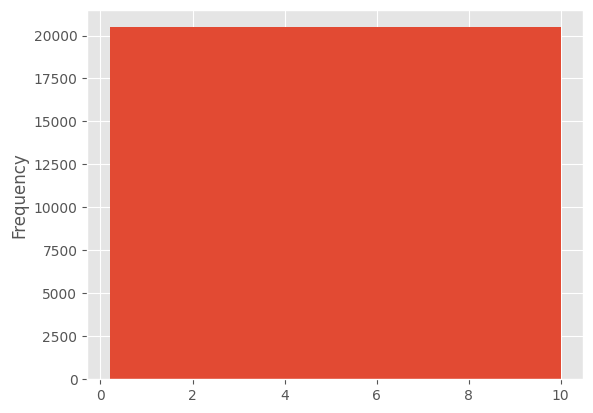

In [12]:
kg_data['rho'].plot.hist(bins=8)

<Axes: ylabel='Frequency'>

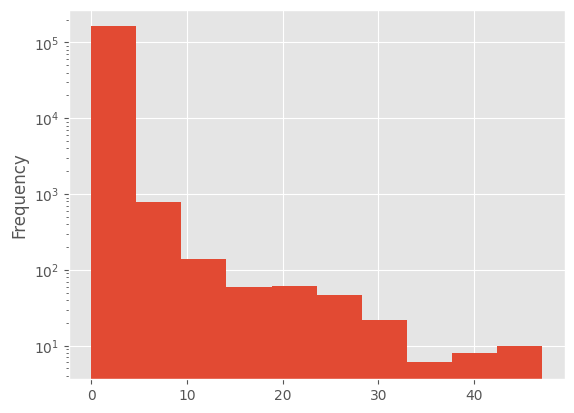

In [13]:
kg_data['w0'].plot.hist(logy=True)#bins=8)

<Axes: ylabel='Frequency'>

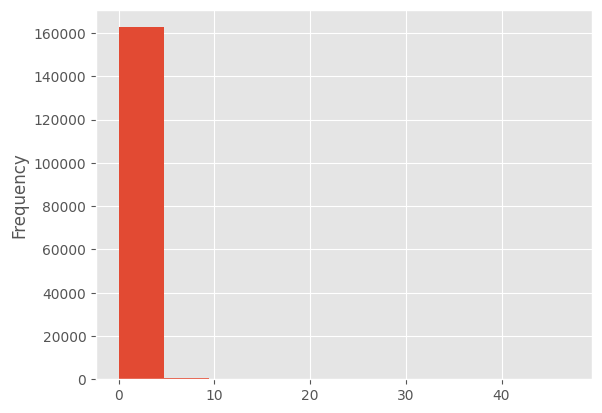

In [14]:
kg_data['w0'].plot.hist()#bins=8)

<Axes: ylabel='Frequency'>

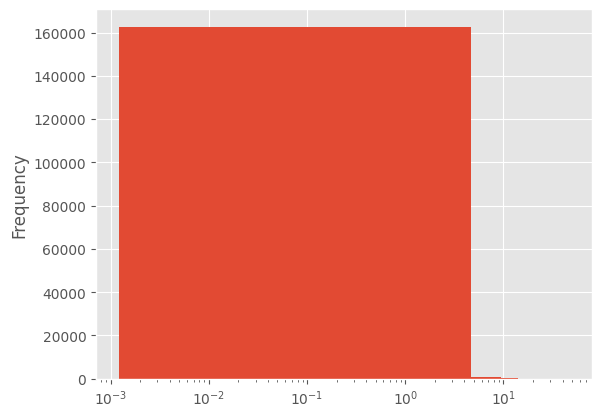

In [15]:
kg_data['w0'].plot.hist(logx=True)

<Axes: ylabel='Frequency'>

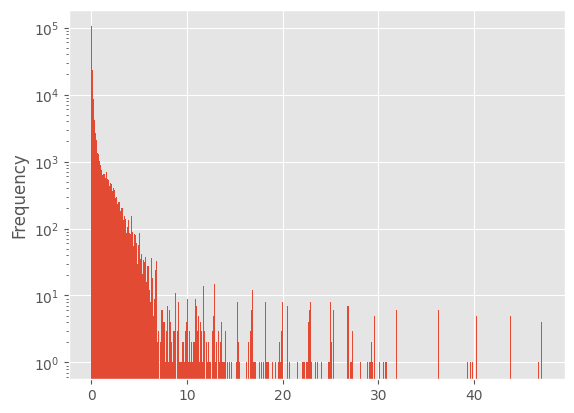

In [16]:
kg_data['w0'].plot.hist(logy=True, bins = 500)

<Axes: ylabel='Frequency'>

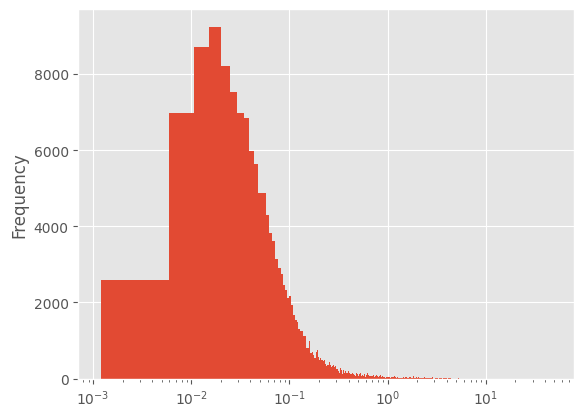

In [17]:
kg_data['w0'].plot.hist(logx=True, bins = 10000)

According to `seaborn` documentation:

A [box plot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

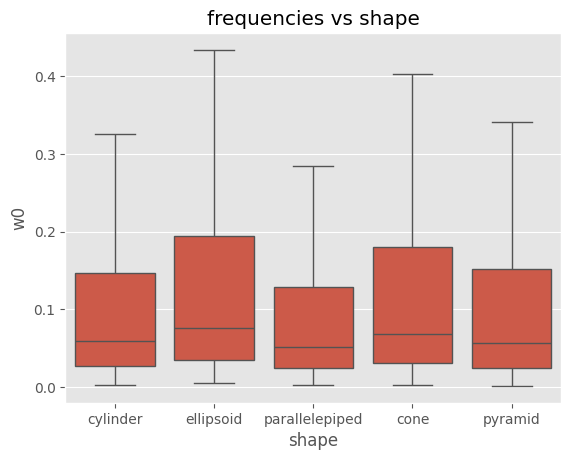

In [18]:
sns.boxplot(x='shape', y='w0', log_scale=False, data=kg_data, showfliers=False)
plt.title('frequencies vs shape');

Now let's look at the distribution of the elastic modulus `K` as a function of the lowest-lying frequency $\omega_0$.

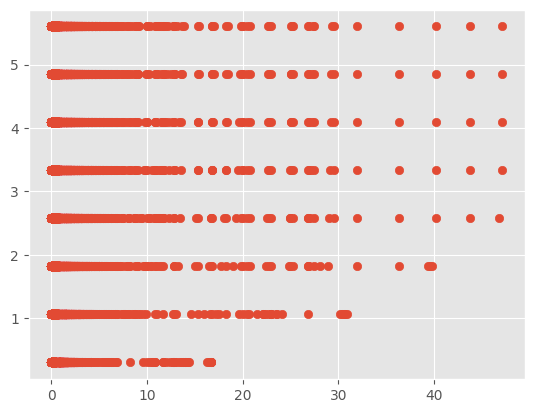

In [19]:
plt.scatter(kg_data['w0'], kg_data['K'])

### QQ plot

Let's generate a plot of sample data against the quantiles of a specified theoretical distribution, in our case the normal distribution because we are interested in linear regression.

One way to assess if data comes from a particular given distribution is by drawing a **Quantile-Quantile plot** (QQ-plot). In a QQ-plot, the quantiles of the data are plotted against the quantiles of the desired distribution. In principle, if the resulting plot is far from being the identity (i.e. the line $y=x$), we can say that our data does not follow the desired distribution.  

Use the function ```stats.probplot(x, dist="norm", plot=plt)``` to verify if the prices of the houses follow a Gaussian distribution.

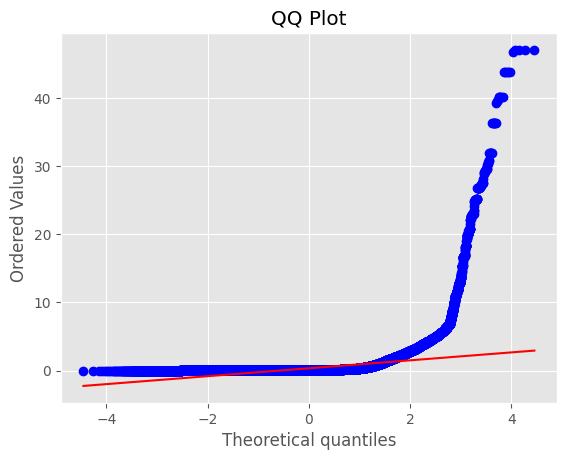

In [20]:
## QQ plot
stats.probplot(x=kg_data['w0'], dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

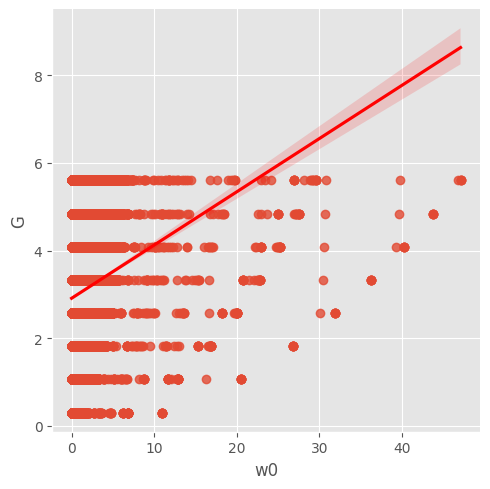

In [21]:
# linear relation between w0 and G
sns.lmplot(x='w0', y='G',data=kg_data, line_kws={'color': "red"})

The distribution does not look normal (Gaussian). Looking at both the QQ plot and the histogram, we can see that the distribution of our data is heavily skewed. (Perhaps a `log` transformation might "fix" things.

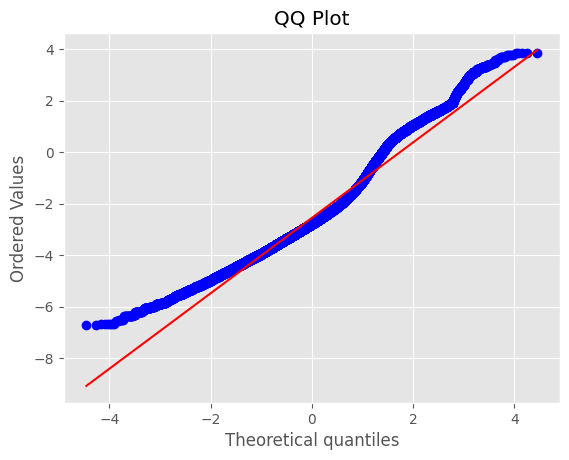

In [22]:
# QQ plot
stats.probplot(x=np.log(kg_data['w0']), dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

Text(0.5, 0, '$\\omega_0$ (MHz)')

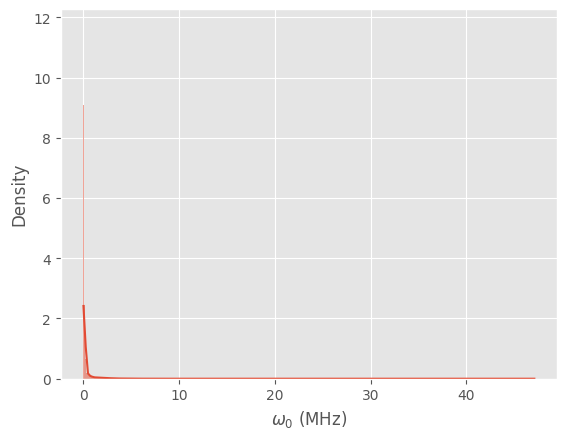

In [23]:
sns.histplot(kg_data['w0'], kde=True, stat='density', linewidth=0)
plt.xlabel(r"$\omega_0$ (MHz)")

Text(0.5, 0, '$\\log(\\omega_0)$')

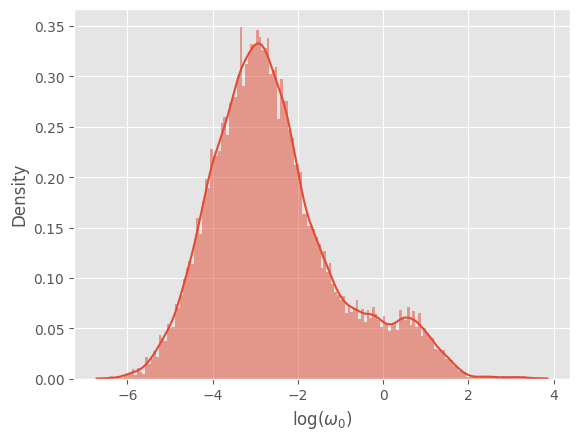

In [24]:
sns.histplot(np.log(kg_data['w0']), kde=True, stat='density', linewidth=0)
plt.xlabel(r"$\log(\omega_0)$")

We can see from both the QQ plot and the histogram that the distribution is far closer to normal, after the log variable transformation. This tells us that the `log` transformation might be a good idea; this will be later "formalized" via a Box-Cox transformation.

### Correlation matrix

To find the variables that have the greatest influence on elastic constants, we can compute a <b>correlation matrix</b> which measures the pairwise correlations between any two variables.

Correlation measures the linear relationship between two variables. The quantity <b>correlation</b> measures how linear the relationship between two variables is.

In [25]:
corr_mat = kg_data.select_dtypes(include=['number']).corr()
corr_mat

,K,G,rho,dx,dy,dz,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9
K,1.000000e+00,-8.303597e-19,2.910665e-15,3.872278e-16,6.844967e-17,1.226267e-17,0.031360,0.028699,0.034081,0.036736,0.031391,0.036168,0.033458,0.035803,0.034029,0.034693
G,-8.303597e-19,1.000000e+00,-3.392659e-15,8.207718e-18,3.661332e-18,-7.872329e-18,0.084484,0.091977,0.095823,0.101610,0.106704,0.105588,0.109759,0.109519,0.112291,0.112849
rho,2.910665e-15,-3.392659e-15,1.000000e+00,3.385949e-15,2.306307e-15,1.623638e-17,-0.337165,-0.362533,-0.389238,-0.408080,-0.419954,-0.424259,-0.432332,-0.437477,-0.443809,-0.447615
dx,3.872278e-16,8.207718e-18,3.385949e-15,1.000000e+00,1.218432e-16,-1.938915e-17,-0.079787,-0.083389,-0.098808,-0.100581,-0.105332,-0.108376,-0.113636,-0.115819,-0.117679,-0.121141
dy,6.844967e-17,3.661332e-18,2.306307e-15,1.218432e-16,1.000000e+00,1.670274e-17,-0.079787,-0.083389,-0.098808,-0.100581,-0.105332,-0.108376,-0.113636,-0.115819,-0.117679,-0.121141
dz,1.226267e-17,-7.872329e-18,1.623638e-17,-1.938915e-17,1.670274e-17,1.000000e+00,-0.037933,-0.038483,-0.048895,-0.049041,-0.047003,-0.053537,-0.056265,-0.056326,-0.055328,-0.059276
w0,3.135985e-02,8.448388e-02,-3.371652e-01,-7.978675e-02,-7.978675e-02,-3.793313e-02,1.000000,0.989448,0.973477,0.964208,0.953749,0.942046,0.925993,0.914046,0.903791,0.888094
w1,2.869859e-02,9.197691e-02,-3.625329e-01,-8.338928e-02,-8.338928e-02,-3.848346e-02,0.989448,1.000000,0.978145,0.972832,0.964310,0.955400,0.941003,0.931421,0.922894,0.906845
w2,3.408129e-02,9.582281e-02,-3.892378e-01,-9.880847e-02,-9.880847e-02,-4.889452e-02,0.973477,0.978145,1.000000,0.991455,0.987296,0.984640,0.977842,0.969772,0.965753,0.955619
w3,3.673554e-02,1.016103e-01,-4.080799e-01,-1.005806e-01,-1.005806e-01,-4.904086e-02,0.964208,0.972832,0.991455,1.000000,0.994502,0.991761,0.987122,0.983524,0.978591,0.970022


Let's produce a heat map showing the results above, but in a more graphical way.

Text(0.5, 1.0, 'Correlation Matrix')

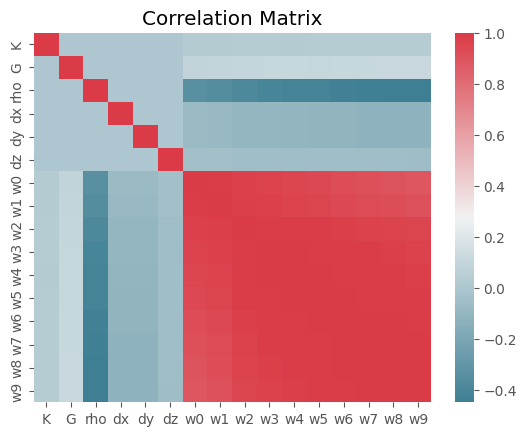

In [26]:
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

## Linear model to predict elastic moduli

Once we identify some independent variables that are correlated with the dependent variable, a linear model can be used to capture this relationship quantitatively. A linear model does this by finding a line that best fits the data points.

We also leverage our [mutual information](https://en.wikipedia.org/wiki/Mutual_information) results to construct the linear models discussed in the rest of this notebook. Apparently, there is no need to normalize the mutual information results. In that case, we know that most relevant features within our data set are the resonant frequencies, and perhaps the density (see below).

A line has two parameters: intercept ($\beta_0$) and slope ($\beta_1$). Thus a linear model for the elastic moduli $C_{IJ}$ vs. density $\rho$, for instance, can be represented as
$$
C_{IJ} = \beta_0 + \beta_1 \rho + \mathrm{error}.
$$
The interpretation of the coefficient $\beta_1$ is the following: an increase of one g/cm^3 in density will on average lead to a change of $\beta_1$ dyn/cm^2. The intercept $\beta_0$ can be thought of as a sort of "baseline" elastic constant. We know that that actually does not make much sense, so I pose the question: **What is the actual meaning of the intercept in a model for elastic constants?**.

The linear model of $(K, G)$ vs. frequencies can be fit as follows:

In [27]:
linmodel_K = 'K ~ rho + w0 + w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 -1'
# linmodel_K = 'K ~ rho*w0*w0 + rho*w1*w1 + rho*w2*w2 + rho*w3*w3 + rho*w4*w4 + rho*w5*w5 + rho*w6*w6 + rho*w7*w7 + rho*w8*w8 + rho*w9*w9 -1'

lm_K = sm.ols(formula=linmodel_K, data=kg_data).fit()
print(lm_K.summary())

                                 OLS Regression Results                                
Dep. Variable:                      K   R-squared (uncentered):                   0.610
Model:                            OLS   Adj. R-squared (uncentered):              0.610
Method:                 Least Squares   F-statistic:                          2.327e+04
Date:                Thu, 15 May 2025   Prob (F-statistic):                        0.00
Time:                        15:46:59   Log-Likelihood:                     -3.5697e+05
No. Observations:              163840   AIC:                                  7.140e+05
Df Residuals:                  163829   BIC:                                  7.141e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### $p$-values

The null hypothesis we are testing here is 
$$
H_0: \beta_1 = 0
$$
and the alternative is
$$
H_a: \beta_1 \neq 0.
$$
The [$p$-value](https://towardsdatascience.com/p-values-explained-by-data-scientist-f40a746cfc8) of most of all features (given under the column: '$P>|t|$' in the results above) is 0.000. Thus, it is statistically significant at the 0.05 level, and we then reject the null hypothesis. This means that the statement "$\beta_1$ is statistically meaningful and different than zero" is true. This implies that density and frequencies do explain some of the differences in pay.

There is no perfect or exact way of setting a statisically significant $p$-value threshold. It really depends on the application. We need domain knowledge for that and this what we have as physicists! $p$-values are used to assess how accurate we think a specific coefficient is. How certain do you need your interpretation of your coefficients to be? Generally, 0.05 is a common heuristic but it is not a hard-line number.

### $R$-squared

One of the key quantities that should be paid attention to while interpreting a regression table is the quantity
[$R$-squared](https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit). This quantity is always going to be between 0 and 1. For the linear model above, this quantity is around 0.608 = 60.8%.

An $R$-squared this large in this linear model means that this observed variation in the elastic moduli is not due to random chance; rather, both frequency and density factors systematically explain 60.8% of this variation in the elastic constants. The higher the $R$-squared, the higher the percentage of observed variation that can be explained by the model. Since the linear model only explains about 60% of the variation, this motivates us to investigate if other factors or non-linearities in the features can be used to explain the differences.

### Linear regression with variable transformation

Since a `log` transformation forces the frequencies to have an apparent distribution closer to normal, let's build a linear model based on this transformation, applied only to the frequencies.

In [28]:
linmodel_K = 'K ~ rho + np.log(w0) + np.log(w1) + np.log(w2) + np.log(w3) + np.log(w4) + np.log(w5) + np.log(w6) + np.log(w7) + np.log(w8) + np.log(w9) -1'

lm_K = sm.ols(formula=linmodel_K, data=kg_data).fit()
print(lm_K.summary())

                                 OLS Regression Results                                
Dep. Variable:                      K   R-squared (uncentered):                   0.695
Model:                            OLS   Adj. R-squared (uncentered):              0.695
Method:                 Least Squares   F-statistic:                          3.394e+04
Date:                Thu, 15 May 2025   Prob (F-statistic):                        0.00
Time:                        15:46:59   Log-Likelihood:                     -3.3678e+05
No. Observations:              163840   AIC:                                  6.736e+05
Df Residuals:                  163829   BIC:                                  6.737e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Box-Cox transformation

The logarithmic transformation discussed above is just on instance of many others (eg. squares, cubes, square roots, etc. as well as trigonometric functions). Choosing the transformatio might be intuitive or not. A more formal way to decide on which transformation to use is to estimate the coefficient $\lambda$ of the [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform):

$$BC(\lambda) = \frac{Y^\lambda-1}{\lambda}$$

This transformation is usually used when the pressumed assumption of linearity between predictor and target is no longer valid. If the estimate of $\lambda$ is close to 2, we can use the quadratic transformation; if it is close to 0.5, the square root transformation; if it is close to zero or less than zero, the logarithmic transformation; etc. In our case, we have:

In [29]:
price, fitted_lambda = stats.boxcox(kg_data['K'])
print('Box-Cox for elastic moduli', round(fitted_lambda, 2))

price, fitted_lambda = stats.boxcox(kg_data['rho'])
print('Box-Cox for density', round(fitted_lambda, 2))

price, fitted_lambda = stats.boxcox(kg_data['w0'])
print('Box-Cox for frequencies', round(fitted_lambda, 2))

Box-Cox for elastic moduli 0.7
Box-Cox for density 0.67
Box-Cox for frequencies -0.18


These results tell us that we also need to apply a variable transformation to the elastic moduli and the density as well. In this case, the proper transformation should be a square root for both variables. Let's try that in a new linear model.

In [30]:
kg_data_train, kg_data_test = train_test_split(kg_data, train_size=0.8)

In [31]:
linmodel_K = 'np.sqrt(K) ~ np.sqrt(rho) + np.log(w0) + np.log(w1) + np.log(w2) + np.log(w3) + np.log(w4) + np.log(w5) + np.log(w6) + np.log(w7) + np.log(w8) + np.log(w9) -1'

lm_K = sm.ols(formula=linmodel_K, data=kg_data_train).fit()
print(lm_K.summary())

                                 OLS Regression Results                                
Dep. Variable:             np.sqrt(K)   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                          7.124e+04
Date:                Thu, 15 May 2025   Prob (F-statistic):                        0.00
Time:                        15:47:18   Log-Likelihood:                     -1.2956e+05
No. Observations:              131072   AIC:                                  2.592e+05
Df Residuals:                  131061   BIC:                                  2.593e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [37]:
y_train_K = lm_K.predict(kg_data_train)
y_test_K = lm_K.predict(kg_data_test)

In [45]:
print('train MAE: ', mean_absolute_error(y_train_K, np.sqrt(kg_data_train["K"])))
print('test MAE: ', mean_absolute_error(y_test_K, np.sqrt(kg_data_test["K"])))
print("train RMSE: ", root_mean_squared_error(y_train_K, np.sqrt(kg_data_train["K"])))
print("test RMSE: ", root_mean_squared_error(y_test_K, np.sqrt(kg_data_test["K"])))
print("train MAPE: ", mean_absolute_percentage_error(y_train_K, np.sqrt(kg_data_train["K"])))
print("test MAPE: ", mean_absolute_percentage_error(y_test_K, np.sqrt(kg_data_test["K"])))
print("train R2: ", np.sum(y_train_K**2)/np.sum(kg_data_train["K"]))
print("test R2: ", np.sum(y_test_K**2)/np.sum(kg_data_test["K"]))

train MAE:  0.5322780147932102
test MAE:  0.5340106193163323
train RMSE:  0.6502227684253494
test RMSE:  0.6514874014119423
train MAPE:  0.39948046776945206
test MAPE:  0.39940959940069487
train R2:  0.8567162658619282
test R2:  0.8587910044364522


In [46]:
linmodel_G = 'np.sqrt(G) ~ np.sqrt(rho) + np.log(w0) + np.log(w1) + np.log(w2) + np.log(w3) + np.log(w4) + np.log(w5) + np.log(w6) + np.log(w7) + np.log(w8) + np.log(w9) -1'

lm_G = sm.ols(formula=linmodel_G, data=kg_data_train).fit()
print(lm_G.summary())

                                 OLS Regression Results                                
Dep. Variable:             np.sqrt(G)   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                          1.078e+05
Date:                Thu, 15 May 2025   Prob (F-statistic):                        0.00
Time:                        17:11:37   Log-Likelihood:                     -1.0568e+05
No. Observations:              131072   AIC:                                  2.114e+05
Df Residuals:                  131061   BIC:                                  2.115e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [47]:
y_train_G = lm_K.predict(kg_data_train)
y_test_G = lm_K.predict(kg_data_test)

In [48]:
print('train MAE: ', mean_absolute_error(y_train_G, np.sqrt(kg_data_train["G"])))
print('test MAE: ', mean_absolute_error(y_test_G, np.sqrt(kg_data_test["G"])))
print("train RMSE: ", root_mean_squared_error(y_train_G, np.sqrt(kg_data_train["G"])))
print("test RMSE: ", root_mean_squared_error(y_test_G, np.sqrt(kg_data_test["G"])))
print("train MAPE: ", mean_absolute_percentage_error(y_train_G, np.sqrt(kg_data_train["G"])))
print("test MAPE: ", mean_absolute_percentage_error(y_test_G, np.sqrt(kg_data_test["G"])))
print("train R2: ", np.sum(y_train_G**2)/np.sum(kg_data_train["G"]))
print("test R2: ", np.sum(y_test_G**2)/np.sum(kg_data_test["G"]))

train MAE:  0.5102173108941658
test MAE:  0.5144820648205664
train RMSE:  0.6205130044304259
test RMSE:  0.6252271461736703
train MAPE:  0.36933702789286194
test MAPE:  0.3733058143972945
train R2:  0.8571122612789042
test R2:  0.857204926404218


**Notice** that the physical motivation for the variable transformations for the density ($\rho$) and the elastic moduli ($K,G$) comes from the fact that for compressional and shear wave speeds are given by
$$
\omega_K = \sqrt{\frac{K}{\rho}}, \qquad \omega_G = \sqrt{\frac{G}{\rho}},
$$
where we have assumed the isotropic case (like the one we're dealing with now).

All features are statistically significant (all $p$-values less than 0.05). This linear model, valid only for $K$, explains over 85% of the total variability of the target (response) variable. The corresponding model for the shear modulus explains over 89% of the variability.

Notice that if the model includes the ``shape`` feature the all features become statistically not meaningful, which cannot have a physical meaning. This might be due to the fact that the model takes into account variables that already predict the elastic moduli in the same way or much better than ``shape`` or ``dimensions``. Thus, the ``shape`` of the sample (specimen) may become less informative when predicting elastic constants.

## Interaction effects

Let's try a linear model that includes interaction effects. As above, this model is motivated by the fact $\sqrt K \sim \sqrt\rho \times \omega$.

In [296]:
linmodel_K = 'np.sqrt(K) ~ np.sqrt(rho) * np.log(w0) + np.sqrt(rho) * np.log(w1) + np.sqrt(rho) * np.log(w2) -1'
# linmodel_K = 'K ~ rho * w0 + rho * w1 + rho * w2 -1'

lm_K = sm.ols(formula=linmodel_K, data=kg_data).fit()
print(lm_K.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             np.sqrt(K)   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                          1.846e+05
Date:                Mon, 23 Sep 2024   Prob (F-statistic):                        0.00
Time:                        18:29:57   Log-Likelihood:                     -1.8630e+05
No. Observations:              196608   AIC:                                  3.726e+05
Df Residuals:                  196601   BIC:                                  3.727e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
np.sqrt(rho)                0.8737      0.002    391.554      0.000       0.869       0.878
np.log(w0)                 -1.8188      0.013   -142.001      0.000      -1.844      -1.794
np.sqrt(rho):np.log(w0)     0.8062      0.006    131.197      0.000       0.794       0.818
np.log(w1)                 -0.5393      0.021    -26.244      0.000      -0.580      -0.499
np.sqrt(rho):np.log(w1)     0.0859      0.009      9.436      0.000       0.068       0.104
np.log(w2)                  2.4438      0.013    194.089      0.000       2.419       2.468
np.sqrt(rho):np.log(w2)    -0.8438      0.006   -134.039      0.000      -0.856      -0.831
==============================================================================
Omnibus:                     7547.064   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5226.691
Skew:                          -0.290   Prob(JB):                         0.00
Kurtosis:                       2.451   Cond. No.                         255.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residual analysis

[**Residual analysis**](https://www.geeksforgeeks.org/residual-analysis/) is a tool for diagnosing many problems that can affect a regression. As we know, the residuals are the difference between the observations and the corresponding fitted values, so they can be positive, zero or negative. Geometrically, a residual represents the distance of the data points to the fitted model (in our case a line).

Let's then focus on linear regression. Residual analysis allows to probe some of the basic theoretical assumptions behind linear regression. The short version is that linear regression works best when the residuals are identically [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution). Notice that there's no such statemen about the data. Linear regression can still be a useful and powerful (and theoretically justified!) tool even if the data deviates from the normality assumption. 

That said, a distribution with fat tails (which is measured by **kurtosis**) is a particular problem for linear regression, because points “in the tails” that are far away from their fitted values can disproportionately affect the fitted coefficients and the predictions. Something similar can be said about the symmetry of the distrubtion (which is measured by **skewness**). An asymmetric distriburion also corresponds to a deviation from identically normally distributed data.

In [297]:
lm_K.resid

0        -0.346784
1        -0.243219
2        -0.219343
3        -0.170209
4        -0.141998
            ...   
196603    0.275633
196604    0.254389
196605    0.239020
196606    0.227384
196607    0.218289
Length: 196608, dtype: float64

### Distribution and QQ plot of the residuals

Let's plot a histogram and a QQ plot of the residuals and see how far they are from the normality assumption.
    
**Hint:** To compare the residuals histogram to a normal distribution, use the ```density=True``` argument of ```plt.hist```, which puts the histogram on the same scale as the normal distribution.

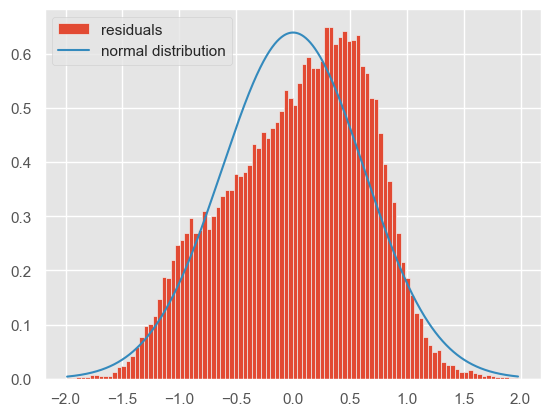

In [302]:
plt.hist(lm_K.resid, bins=100, label="residuals", density=True)    # the histogram integrates to 1

# now plot the normal distribution for comparison
xx = np.linspace(lm_K.resid.min(), lm_K.resid.max(), num=1000)
plt.plot(xx, stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(lm_K.scale)), label="normal distribution")

# change otherwise the rugplot has the same color as the histogram
outliers = np.abs(lm_K.resid) > 4 * np.sqrt(lm_K.scale)
sns.rugplot(lm_K.resid[outliers], label="outliers", color="C5") 

plt.legend(loc="upper left");

We also create the QQ plot of the residuals, which shows nonlinearity and is another strong warning sign regarding the normality hypothesis of the residuals.

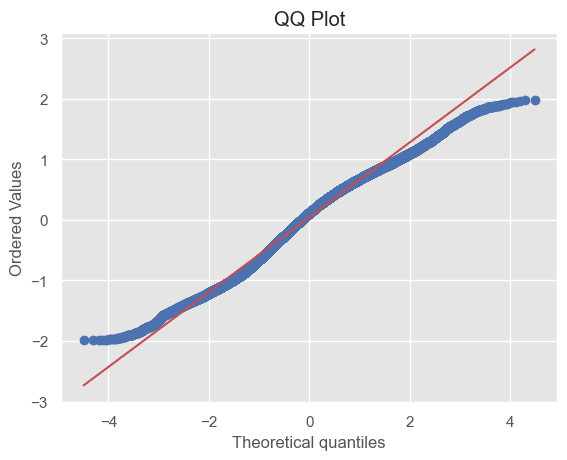

In [300]:
# statsmodels.api.qqplot(lm_K.resid, line="s");
stats.probplot(x=lm_K.resid, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

### Skewness and Kurtosis

If the residuals are less skewed, and the tails of the distribution are less fat, this is a good sign. This can be deduced from the `Skew` and `Kurtosis` metrics at the bottom of the summaries of the models. See all the linear models we have fitted above.

[Skewness](https://en.wikipedia.org/wiki/Skewness) is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. The skewness value can be positive, zero, negative, or undefined (think of power-law distributions). Zero skewness means that the distribution is balanced around the mean; however, this does not imply that the distribution is symmetric. Indeed, an asymmetric distribution where one tail is long and thin, and the other is short but fat can have a zero skewness. Pearson's skewness is defined as `skew = mean - mode`.

[Kurtosis](https://en.wikipedia.org/wiki/Kurtosis) is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. It's a measure of "tailedness". Excess kurtosis, typically compared to a value of 0, characterizes how heaby the tails of a distribution are. A univariate normal distribution has an excess kurtosis of 0. For comparison, the logistic distribution has an excess kurtosis of 1.2, and a Laplace distribution has a value of 3. On the other hand, a uniform distribution has an excess kurtosis of -1.2.

### Heteroscedasticity

Residual analysis can also yield information on the notion of [**heteroscedasticity**](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity), which means that the residuals have small variance for in some subsets of the data, and high variance in others. This is also known as heterogeneity of variance. The opposite of heteroscedasticity is **homoscedasticity**, which is what we want to see in the data, and means that the residuals have similar variance across all subsets of the data. This is also known as homogeneity of variance. (Read more about this and how to analyze it somewhere else, you can start with the Wikipedia page linked above.)